In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import xarray as xr

In [2]:
### Directory management
in_dir = Path('/scratch/orybchuk/wakedynamics/bcs-ldm/palette/sampling/test_sample_y11520_240723_145300/results/test')
cond_files = list(in_dir.glob('*/Input*npy'))
cond_files.sort()
in_files = list(in_dir.glob('*/Out*npy'))
in_files.sort()
n_samples = len(in_files)

# f_out = Path('processed_data/240606/y11520.nc')

In [3]:
### Drop duplicate date generated on each GPU
n_gpus = 4
in_files = in_files[::n_gpus]

n_ens_out = 32
in_files = in_files[:n_ens_out]

In [4]:
def unnorm(xp, xmin, xmax):
    '''
    Take data from [-1,1] back to the original values
    '''
    return (xp + 1)*0.5*(xmax-xmin)+xmin

In [5]:
### Load data
tmp_arr = np.load(in_files[0])
cond_arr = np.zeros((n_ens_out,)+tmp_arr.shape)
in_arr = np.zeros((n_ens_out,)+tmp_arr.shape)

for isamp in range(n_ens_out):
    cond_arr[isamp] = np.load(cond_files[isamp]).copy()
    in_arr[isamp] = np.load(in_files[isamp]).copy()
    
# Un-normalize data
umin, umax = 3.214014355133783, 15.289255055189235
vmin, vmax = -5.653542266524573, 6.534358873692452
wmin, wmax = -4.2332768669062615, 6.379011318431806
Tmin, Tmax = 317.8989310331773, 320.45569693188133
TKEmin, TKEmax = 0.0, 0.8424542759164027

cond_arr[:,0,:,:] = unnorm(cond_arr[:,0,:,:], umin, umax)
cond_arr[:,1,:,:] = unnorm(cond_arr[:,1,:,:], vmin, vmax)
cond_arr[:,2,:,:] = unnorm(cond_arr[:,2,:,:], wmin, wmax)
cond_arr[:,3,:,:] = unnorm(cond_arr[:,3,:,:], Tmin, Tmax)
cond_arr[:,4,:,:] = unnorm(cond_arr[:,4,:,:], TKEmin, TKEmax)

in_arr[:,0,:,:] = unnorm(in_arr[:,0,:,:], umin, umax)
in_arr[:,1,:,:] = unnorm(in_arr[:,1,:,:], vmin, vmax)
in_arr[:,2,:,:] = unnorm(in_arr[:,2,:,:], wmin, wmax)
in_arr[:,3,:,:] = unnorm(in_arr[:,3,:,:], Tmin, Tmax)
in_arr[:,4,:,:] = unnorm(in_arr[:,4,:,:], TKEmin, TKEmax)

In [6]:
### Reformat to Xarray
coords_batch = range(n_ens_out)
coords_time = np.arange(in_arr.shape[2])
coords_y = np.arange(-160, 160, 10)
coords = {'ens': coords_batch,
          'time': coords_time,
          'y': coords_y}
ds_out = xr.Dataset(coords=coords)

ds_out['u'] = (('ens', 'time', 'y'), in_arr[:,0,:,:])
ds_out['v'] = (('ens', 'time', 'y'), in_arr[:,1,:,:])
ds_out['w'] = (('ens', 'time', 'y'), in_arr[:,2,:,:])
ds_out['T'] = (('ens', 'time', 'y'), in_arr[:,3,:,:])
ds_out['TKE'] = (('ens', 'time', 'y'), in_arr[:,4,:,:])

ds_out.to_netcdf(f_out)

In [7]:
### Reformat to Xarray
ds_cond = xr.Dataset(coords=coords)

ds_cond['u'] = (('ens', 'time', 'y'), cond_arr[:,0,:,:])
ds_cond['v'] = (('ens', 'time', 'y'), cond_arr[:,1,:,:])
ds_cond['w'] = (('ens', 'time', 'y'), cond_arr[:,2,:,:])
ds_cond['T'] = (('ens', 'time', 'y'), cond_arr[:,3,:,:])
ds_cond['TKE'] = (('ens', 'time', 'y'), cond_arr[:,4,:,:])


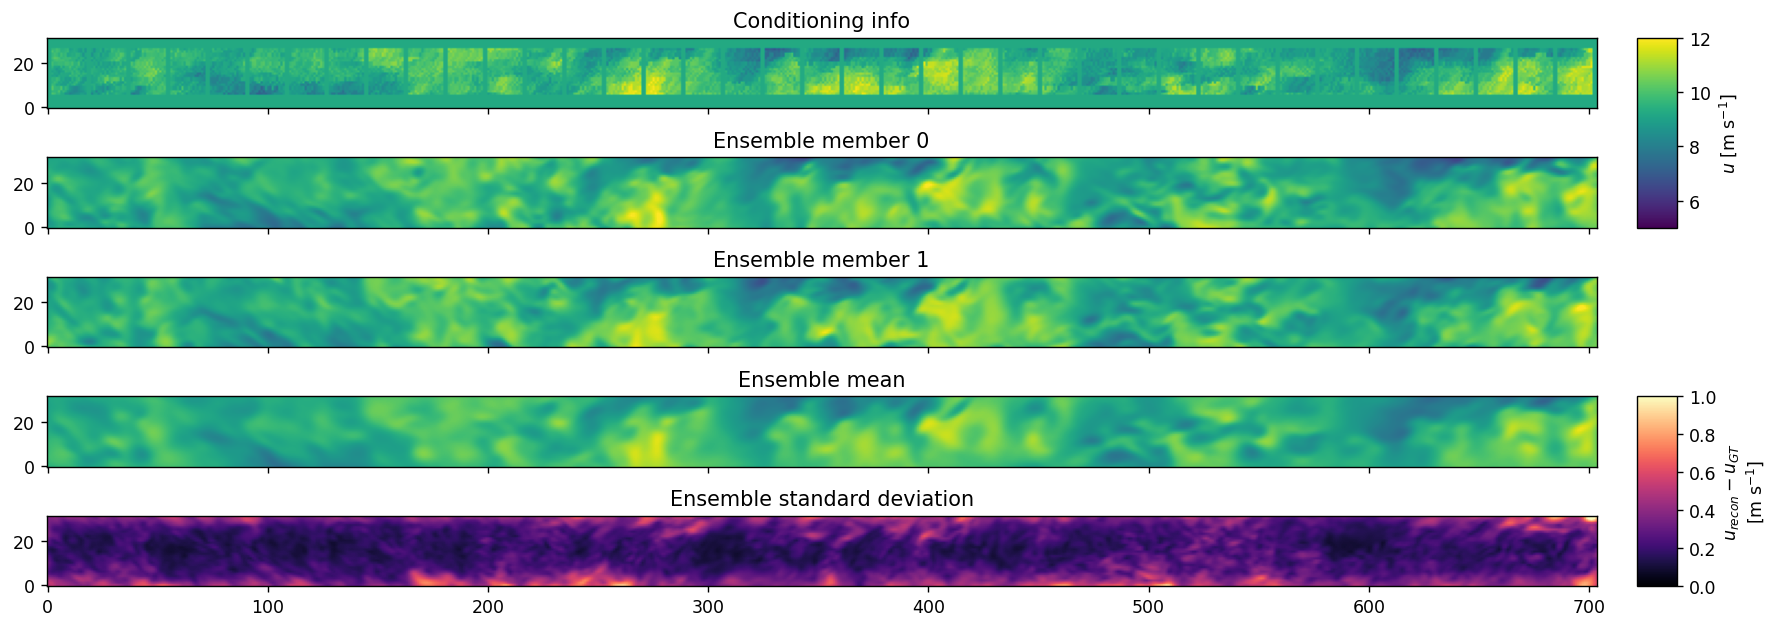

In [8]:
### Compare hub-height views of GT, conditioning, and recons
fig, ax = plt.subplots(5, 1, figsize=(16,6), dpi=125, sharex=True)


# Grab data
plttmin, plttmax = 0, 704

data0 = ds_cond['u'].isel(time=slice(plttmin, plttmax),ens=0).values.T
data1 = ds_out['u'].isel(time=slice(plttmin, plttmax),ens=0).values.T
data2 = ds_out['u'].isel(time=slice(plttmin, plttmax),ens=5).values.T
# data1 = ds_recon_plt['velocityx'].isel(time=slice(plttmin, plttmax),ens=0).values.T
data3 = ds_out['u'].isel(time=slice(plttmin, plttmax)).mean('ens').values.T
data4 = ds_out['u'].isel(time=slice(plttmin, plttmax)).std('ens').values.T

# Plot
vmin, vmax = 5, 12

im0 = ax[0].imshow(data0,
                 origin='lower',
                 vmin=vmin,
                 vmax=vmax)
im1 = ax[1].imshow(data1,
                 origin='lower',
                 vmin=vmin,
                 vmax=vmax)
im2 = ax[2].imshow(data2,
                 origin='lower',
                 vmin=vmin,
                 vmax=vmax)
im3 = ax[3].imshow(data3,
                 origin='lower',
                 vmin=vmin,
                 vmax=vmax)
im4 = ax[4].imshow(data4,
                 origin='lower',
                 vmin=0,
                 vmax=1,
                 cmap='magma')

# Colorbars
cax0 = fig.add_axes([ax[-1].get_position().x1+0.02,
                     ax[1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('$u$ [m s$^{-1}$]')
cbar0.ax.tick_params()

cax4 = fig.add_axes([ax[-1].get_position().x1+0.02,
                     ax[4].get_position().y0,
                     0.02,
                     ax[3].get_position().y1-ax[4].get_position().y0])
cbar4 = fig.colorbar(im4, cax=cax4)
cbar4.set_label('$u_{recon} - u_{GT}$\n[m s$^{-1}$]')
cbar4.ax.tick_params()

# cax4 = fig.add_axes([ax[-1].get_position().x1+0.02,
#                      ax[4].get_position().y0,
#                      0.02,
#                      ax[4].get_position().y1-ax[4].get_position().y0])
# cbar4 = fig.colorbar(im4, cax=cax4)
# cbar4.set_label('$\sigma_{u,recon}$\n[m s$^{-1}$]')
# cbar4.ax.tick_params()

# Decorate
ax[0].set_title("Conditioning info")
ax[1].set_title("Ensemble member 0")
ax[2].set_title("Ensemble member 1")
ax[3].set_title("Ensemble mean")
ax[4].set_title("Ensemble standard deviation")
# ax[4].set_title("Std. dev. of $n=30$ reconstructions")


plt.show()

In [9]:
# ### Compare hub-height views of GT, conditioning, and recons
# fig, ax = plt.subplots(4, 1, figsize=(16,6), dpi=125, sharex=True)


# # Grab data
# plttmin, plttmax = 0, 240

# data0 = ds_out['T'].isel(time=slice(plttmin, plttmax),ens=0).values.T
# data1 = ds_out['T'].isel(time=slice(plttmin, plttmax),ens=1).values.T
# # data1 = ds_recon_plt['velocityx'].isel(time=slice(plttmin, plttmax),ens=0).values.T
# data2 = ds_out['u'].isel(time=slice(plttmin, plttmax)).mean('ens').values.T
# data3 = ds_out['u'].isel(time=slice(plttmin, plttmax)).std('ens').values.T

# # Plot
# vmin, vmax = 317, 320

# im0 = ax[0].imshow(data0,
#                  origin='lower',
#                  vmin=vmin,
#                  vmax=vmax)
# im1 = ax[1].imshow(data1,
#                  origin='lower',
#                  vmin=vmin,
#                  vmax=vmax)



# plt.show()

In [10]:
tmp_arr.shape

(5, 704, 32)

In [11]:
tmp_arr[0].max()

0.47699782